(basic-ccd-reductions)=

# Basic CCD reductions

"Reduction" is the term used to describe the general process of taking raw data from a CCD camera and performing a series of operations to produce a final image in which we have removed as many of the systematic trends and defects that affect the original image. Very generally, the steps in the reduction process are:

- Bias subtraction
- Dark correction
- Flat field correction
- Cosmic ray removal
- Bad pixel masking

Often there are other steps such as astrometric and photometric calibration that are part of the reduction process, but we will discuss those at a later time.

## Datasets

For this lecture we will use a [set of images](https://doi.org/10.5281/zenodo.3254683) taken using the Palomar Large Format Camera (LFC) on the Hale 200-inch telescope. Technical details about the camera can be found [here](https://sites.astro.caltech.edu/palomar/observer/200inchResources/lfcspecs.html). The dataset include several bias, flat, dark, and science images from one of the 6 detectors in the LFC mosaic, and can be downloaded from [here](https://zenodo.org/record/3254683/files/example-cryo-LFC.tar.bz2?download=1).

We will also use another [set of images](https://zenodo.org/records/3245296) from an Andor Aspen CG16M camera. You can download them [here](https://zenodo.org/record/3245296/files/example-thermo-electric.tar.bz2?download=1). After you download the datasets and copy them to the location where you want to use them, you can decompress them by doing

```bash
tar cjvf example-cryo-LFC.tar.bz2
```

Many of the steps in this lecture follow the structure of the [CCD Data Reduction Guide](https://www.astropy.org/ccd-reduction-and-photometry-guide/v/dev/notebooks/00-00-Preface.html) which uses the same datasets.

:::{note}
You can download this lecture as {nb-download}`ccd_reductions.ipynb` or {download}`ccd_reductions.md` and follow along. For that make sure that you change the values of the `LFC_DIR` and `ANDOR_DIR` variables to point to the directory where you have your data.
:::

In [1]:
%matplotlib inline

import os
import seaborn
from astropy.io import fits
from matplotlib import pyplot as plt

seaborn.set_palette('deep', color_codes=True)
plt.ion()

# Change these paths to point to the location of your data
LFC_DIR = '../../data/example-cryo-LFC/'
ANDOR_DIR = '../../data/ccd_reductions_data/'

# This moves the current working directory to the location of the LFC data
os.chdir(LFC_DIR)

## Bias and overscan

Analog-to-digital converters (ADC) require the signal that they work with to have a positive charge. To avoid cases in which this could be a problem, a small _bias_ voltage is added to the output signal before it reaches the ADC. Ideally this bias level would be constant, but in practice the level varies by small amounts from pixel to pixel and during the night as the outside temperature changes.

Our first step in the reduction process is to remove the contribution from the bias level by measuring its median level and subtracting it from any other image we have taken that night (_all_ images are affected by the bias level, not only science frames). To achieve this there are typically two alternatives: the use of a series of zero-exposure images (bias frames) or using a special part of the image called the _overscan_ region.

### Bias frames

Bias frames are images that are taken with zero exposure time and the shutter closed. Most cameras have a special mode to take these image. With no exposure time there is no signal (photons) reaching the surface of the CCD, so the only things that we are reading as we generate the digital image is the bias level and the readout noise (and a small amount of dark current that, if the camera is properly cooled, is usually negligible). From a bias frame the average value across the image (mean, median, mode) is an estimate of the bias level while the standard deviation gives us the readout noise.

In the LFC dataset the bias frames are images 1 to 6. Let's open one of them:

In [2]:
bias = fits.open('ccd.001.0.fits')
bias.info()

Filename: ccd.001.0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   (2080, 4128)   int16 (rescales to uint16)


The image contains a single extension or HDU, with an image frame that is 2080, 4128 pixels and a header with 43 keywords. Let's quickly look at the header:

In [3]:
bias[0].header

SIMPLE  =                    T  / STANDARD FITS                                 
BITPIX  =                   16  / BITS/PIXEL                                    
NAXIS   =                    2  / NUMBER OF AXES                                
NAXIS1  =                 2080  / NUMBER OF COLUMNS                             
NAXIS2  =                 4128  / NUMBER OF ROWS                                
BSCALE  =        1.0000000E+00  / PHYSICAL = BSCALE * DATA + BZERO              
BZERO   =               32768.                                                  
DATE    = '2016-01-15'          / UT Date of file creation (DD/MM/YY)           
ORIGIN  = 'California Institute of Technology'  / Palomar Observatory           
LATITUDE=              33.4000  / Latitude (degrees N)                          
LONGITUD=            -116.9000  / Longitude (degrees E)                         
TELESCOP= 'Hale 5m Telescope'   / Telescope used for observation                
FRATIO  =               7.50

The header tells us useful stuff about the instrument, when this image was taken, etc. The last few keywords are useful for data reduction. `CCDSEC` and `DATASEC` tells use the region of the image that contains valid data, while `BIASSEC` tells us where the overscan region is located. These keywords are a legacy from a reduction software called [IRAF](https://iraf-community.github.io/), which is still used by many astronomers.

:::warning
The pixel values in `DATASEC` and others are 1-indexed, while in Python we use 0-indexed arrays.
:::

Let's now look at one of the images. We will use some tools in [astropy.visualization](https://docs.astropy.org/en/stable/visualization/normalization.html) to normalise the image for display:

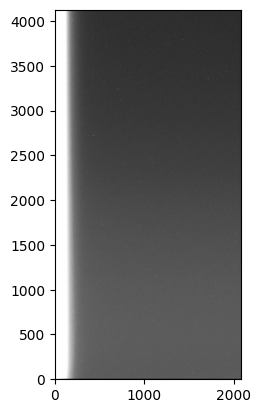

In [4]:
from astropy.visualization import ImageNormalize, LinearStretch, ZScaleInterval

data = bias[0].data.astype('f4')
norm = ImageNormalize(data, interval=ZScaleInterval(), stretch=LinearStretch())

image = plt.imshow(data, origin='lower', norm=norm, cmap='gray')

Note that before I started doing anything to the image I converted the data to a `float32` array by doing `.astype('f4')` (I could have also done `.astype(numpy.float32)`). Normally raw CCD frames are encoded as unsigned-integer 16-bit, which is enough to containe the values 0-65,535 that 16-bit ADC generate, but that data format can cause problems ---mainly due to overflow--- once we start doing operations on them.

We can see several things in the image. First, it is quite flat, as we would expect, but there is a significant gradient on the left side. This is probably due to electronic noise if the readout hardware is on that part of the chip. Let's have a look at how significant this gradient is. Let's collapse the image along the y-axis (the first axis in the `numpy` array, remember that `numpy` arrays are 0-indexed and arranged such that the first axis is rows and the second axis is columns) and plot the result:

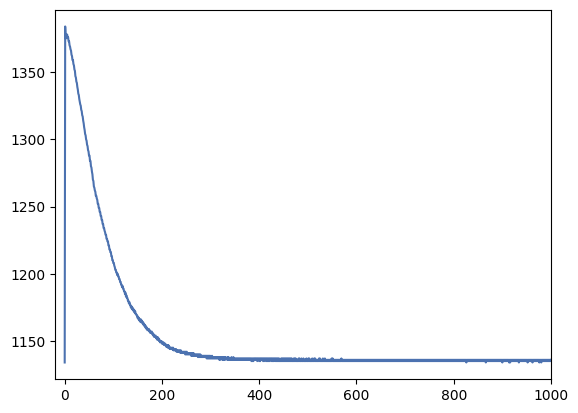

In [5]:
import numpy

# Collapse the image along the y-axis
bias_profile = numpy.median(data, axis=0)

# Plot the result and focus on the left side of the images. The _ = are a trick to
# avoid printing the result of the plot command.
_ = plt.plot(bias_profile)
_ = plt.xlim(-20, 1000)

Most of the image has a fairly constant bias level of about 1140 but the left side gradient reaches over 1350 counts. We'll want to avoid this region by trimming or ignoring the first 300-400 pixels of the image (unless we can proof that this gradient is very constant over time and we can correct for it).

Let's now quickly look at the average levels (bias) and the standard deviation (readout noise) of the image. We will use the median which is more robust against outliers than the mean. For these images in which all values are integers the mode is also a good choice.

In [6]:
bias = numpy.median(data)
readout_noise = numpy.std(data)

print(f'Bias: {bias} counts')
print(f'Readout noise: {readout_noise:.2f} counts')

Bias: 1137.0 counts
Readout noise: 43.30 counts


This approximately matches what we saw in the profile plot. However we are averaging over the entire image, which includes the overscan region and also the gradient. In general it is always a good idea to use smaller regions that we have confirmed are not affected by any systematic effects. Let's repeat the calculation but by taking a smaller region around $(2000, 1000)$.

In [7]:
# Define the region of interest. Note that the first axis is y and the second axis is x.
region = data[1000:1500, 2000:2500]

bias = numpy.median(region)
readout_noise = numpy.std(region)

print(f'Bias: {bias} counts')
print(f'Readout noise: {readout_noise:.2f} counts')

Bias: 1138.0 counts
Readout noise: 3.82 counts


The bias level has not changed much but the readout noise has decreased dramatically! This is not unexpected since we are not averaging over a very flat region that should only be affected by the readout noise. Note that both the bias level and readout noise here are measured in counts or ADU. We will see later how to convert these values to electrons.

### CCD corrections are noisy

An important concept to remember is that **it is not possible to remove noise from an image**. Here "noise" refers to the random fluctuations in the pixel values due to statistical noise (for example the Poisson or "shot" noise inherent to the arrival of photons). Sometimes noise is also used to refer to systematic effects that are we see in the image, such as the bias level or the flat field. The latter are the trends that we can measure and correct for, but the noise that they introduce (e.g., the readout noise) cannot be removed. In fact, applying a correction to an image will always add noise to the image unless the correction is perfect, which is hardly ever the case.

The best way to avoid compounding our noise problem is by using corrections that introduce as little noise as possible. One way to achieve this is to take multiple images for each type of correction and combine them. Error propagation theory tells us that when we average multiple images with the same noise level the resulting image has a noise level that is reduced by a factor of $\sqrt{N}$, where $N$ is the number of images. Let's prove that.

We start by creating an image with a known mean level and noise. We'll draw the values from a Gaussian distribution with mean 500 and standard deviation 10. This can be done easily using `scipy` and `numpy` but we'll use the function [make_noise_image](https://photutils.readthedocs.io/en/stable/api/photutils.datasets.make_noise_image.html) from `photutils`.

In [8]:
from photutils.datasets import make_noise_image

# Create a noise image with a mean of 500 and standard deviation of 10
noise_image = make_noise_image((1000, 1000), mean=500, stddev=10, distribution='gaussian')

print(noise_image.shape)
print(f'Mean: {numpy.mean(noise_image):.5f}')
print(f'Standard deviation: {numpy.std(noise_image):.5f}')

(1000, 1000)
Mean: 500.01001
Standard deviation: 10.00482


Now we'll create multiple of these image and average them. To do that we create a list which we then convert into a 3D array. We can then use `numpy.mean` to calculate the mean along the first axis. This will result in a 2D image with the same shape as the original images in which each pixels is the average of the values in that pixel across all images.

In [9]:
# Create a list of noise images
noise_images = [make_noise_image((1000, 1000), mean=500, stddev=10, distribution='gaussian') for _ in range(5)]
print(f'Number of images: {len(noise_images)}')

# Convert the list into a 3D array
noise_images_3d = numpy.array(noise_images)
print(f'Shape of the 3D array: {noise_images_3d.shape}')

# Calculate the mean along the first axis
mean_image = numpy.mean(noise_images_3d, axis=0)
print(f'Shape of the mean image: {mean_image.shape}')

# Calculate the mean and standard deviation of the resulting image
mean = numpy.mean(mean_image)
stddev = numpy.std(mean_image)

print(f'mean: {mean:.5f}')
print(f'Standard deviation: {stddev:.5f}')

Number of images: 5
Shape of the 3D array: (5, 1000, 1000)
Shape of the mean image: (1000, 1000)
mean: 500.00027
Standard deviation: 4.47711


As expected the mean has not changed but the standard deviation has decreased. From an original standard deviation of 10 for each image we would expect the resulting image to have a standard deviation of $10/\sqrt{5} = 4.472$ which is very close to what we see.

:::warning
This example does not work as well if you use the median instead of the mean. The $\sqrt{N}$ factor only applies to the mean, which the standard deviation of the mean decreasing as $N$ increases but more slowly then with the mean.
:::

### Combining multiple images

Let's now combine several real bias frames and look at the resulting image. The process is similar to what we saw above but now we'll open all images 1-6 from our dataset:

In [10]:
bias_images = []

for i in range(1, 7):
    bias_data = fits.getdata(f'ccd.00{i}.0.fits')
    bias_images.append(bias_data.astype('f4'))

# Convert the list into a 3D array
bias_images_3d = numpy.array(bias_images)
bias_mean_2d = numpy.mean(bias_images_3d, axis=0)

# Calculate the median and standard deviation on a small region
region = bias_mean_2d[1000:1500, 2000:2500]
bias_median = numpy.median(region)
bias_std = numpy.std(region)

print(f'Median: {bias_median:.2f}')
print(f'Standard deviation: {bias_std:.2f}')

Median: 1125.00
Standard deviation: 2.03


The bias level has decreased a bit, which we can explain as some outliers (mostly cosmic rays as we'll see later) getting averaged out. The standard deviation has also decreased, as we expected from the previous section. Instead od the expected $3.82/\sqrt{6}\sim 1.56$ we see a higher value of $\sim 2$. This tells us that the distribution of the bias noise is not perfectly Gaussian, which is not unexpected. This example shows that there is a limit to how much we can reduce the noise by averaging real images. During observations we'll want to take as many bias (and other calibration frames) as possible but taking into account that there is a trade-off between the time we spend taking these images and the time we spend taking science images.

There is however another trick that we can employ when combining images. So far we have treated all images equally, and there is not reason not to do so. But at the pixel level we will often found that the value for that pixel in one image is significantly different from the others. This can be caused by cosmic rays or electronic misbehaviours. We would like to be able to identify those outliers and ignore them when calculating the combined image. The solution is what we call _sigma-clipping_.

With sigma-clipping the idea is that for each pixel we take all the values that contribute to the combined pixel and calculate the median (or mean or mode) and the standard deviation. Then we determine how many times the standard deviation each value is with respect to the median. If a values is away from the median by more than a certain number of standard deviations we consider it an outlier and reject it. We then repeat the process iteratively until there are no more outliers (or we reach a minimum number of points that we want to keep). The resulting image will be the median of the original images but with a strong robustness against outliers.

It's easy to implement a sigma-clipping algorithm in Python (and you should try it!) but for convenience we can use `astropy`'s implementation in [astropy.stats.sigma_clip](https://docs.astropy.org/en/stable/api/astropy.stats.sigma_clip.html)

In [11]:
from astropy.stats import sigma_clip

# Call sigma_clip with a threshold of 2.5 sigmas and using the median as the central function.
# The result is a list of masked arrays in which pixels that are outliers are masked.
# Note that we need to use the axis=0 argument to tell sigma_clip that we want
# to apply it along the first axis.
bias_images_masked = sigma_clip(bias_images, cenfunc='median', sigma=2.5, axis=0)

print(f"Number of elements: {len(bias_images_masked)}")
print(f"Type of the first element: {type(bias_images_masked[0])}")
print(f"Number of pixels masked in the first image: {bias_images_masked[0].mask.sum()}")

Number of elements: 6
Type of the first element: <class 'numpy.ma.MaskedArray'>
Number of pixels masked in the first image: 443965


You can try the previous code with different values of `sigma` and see how the number of masked pixels changes. Now let's create the combined image using the masked arrays.

In [12]:
# Calculate the mean along the first axis. We use the ma module
# to handle masked arrays correctly.
bias_sc_mean_2d = numpy.ma.mean(bias_images_masked, axis=0)
print(f"Shape of the combined image: {bias_sc_mean_2d.shape}")
print(f"Type of the combined image: {type(bias_sc_mean_2d)}")

# Calculate the mean and standard deviation on a small region.
region = bias_sc_mean_2d[1000:1500, 2000:2500]
bias_mean = numpy.ma.mean(region)
bias_std = numpy.ma.std(region)

print(f'Mean: {bias_mean:.2f}')
print(f'Standard deviation: {bias_std:.2f}')

Shape of the combined image: (4128, 2080)
Type of the combined image: <class 'numpy.ma.MaskedArray'>
Mean: 1124.85
Standard deviation: 2.20


We see a slight increase in our estimation of the readout noise. This is not unexpected since now many mean pixel values are being calculated from fewer images. This process may need to be repeated with several values of the sigma-clip threshold until a good compromise is found between robustness against outliers and not discarding too many images.

:::note
Although we have used it with a set of 2D images here, the `sigma_clip` function can be used with any n-dimensional array.
:::

### Overscan region

The overscan region is an area of the CCD image in many professional cameras. It is generated by reading "fake" pixels that are not part of the real image (i.e., they do not correspond to any physical pixels on the CCD). This is done by telling the readout electronics to continue reading a number of pixels after each row in the serial register. Since these pixels are not really part of the image, what we read is just the contribution of the bias level and the readout noise generated by the readout electronics.

Overscan regions are useful because of two reasons:

- They are a very good estimate of the bias level at each row that is unaffected by differences between pixels.
- It is taken with each image (regardless of the type of exposure and exposure time) so it can be used to track the changes in the bias level during the night.

There are also a few caveats to the use of the overscan region:

- The overscan region is only a few pixels wide per row, so our statistics of the bias level will be poorer. In general it is not a good idea to use the overscan region to estimate the readout noise.
- If the bias level changes across the row the overscan region may not be able to track it.

With these pros and cons in mind, let's look at the overscan region of one of our images. The `BIASSEC` keyword in the header tells us that the overscan region in the LFC images is located at the end of each row (the last $\sim 30$ columns of each row). However if we zoom on that region on a bias frame we won't see anything special. That's expected since the bias and overscan should have the same levels. Instead, let's use a flat image which we'll describe later. For now we just need to know that this is an image created with a uniform illumination of the CCD and relatively high signal levels. Images 14-19 in the LFC dataset are flat images.

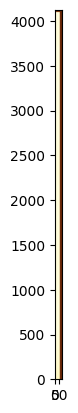

In [13]:
from astropy.visualization import ZScaleInterval

flat = fits.open('ccd.014.0.fits')
flat_data = flat[0].data.astype('f4')

# Plot around the overscan region.
overscan_zoom = flat_data[:, 2000:]

norm = ImageNormalize(overscan_zoom, interval=ZScaleInterval(), stretch=LinearStretch())
_ = plt.imshow(overscan_zoom, origin='lower', norm=norm, cmap='YlOrBr_r')
_ = plt.ylim(0, 4128)

:::note
In reality it seems that this camera has two overscan regions, one at the end of each row and one at the end of each column. Since the header recommends using the overscan region at the end of each row, we will use that one.
:::

Let's take vertical and horizontal profiles of the overscan region to see how flat it is.

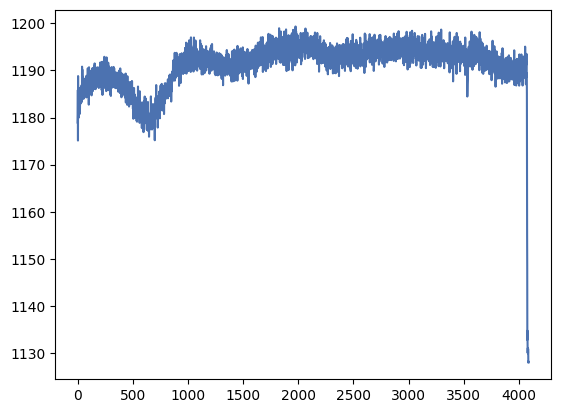

In [14]:
# Select the overscan region. Remove some pixels from the edges to avoid weird effects.
overscan = flat_data[20:-20, 2048:]

# Collapse the image along the x-axis and plot the result
overscan_profile_x = numpy.mean(overscan, axis=1)
_ = plt.plot(overscan_profile_x)

We see that the overscan is reasonably flat but there are some fluctuations as we move along the y-axis. They are, however, smooth variations which may lead us to believe that they are real. Let's check the other direction.

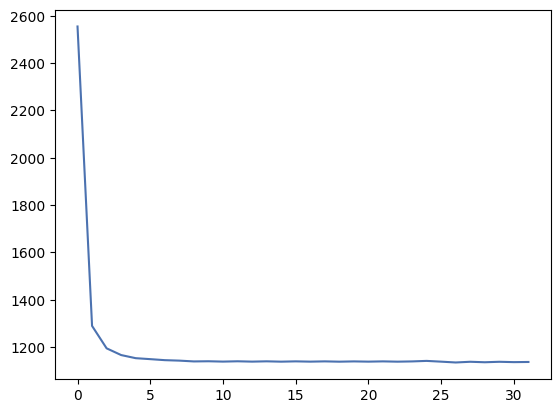

In [15]:
overscan_profile_y = numpy.mean(overscan, axis=0)

_ = plt.plot(overscan_profile_y)

It seems the overscan does not really start at index 2048 as we expected, and that for the first few pixels in each row it decreases until it reaches a more constant value. This is a normal behaviour, caused by residual charge from previous pixels in the row. Let's ignore the first 5 pixels in each overscan row.

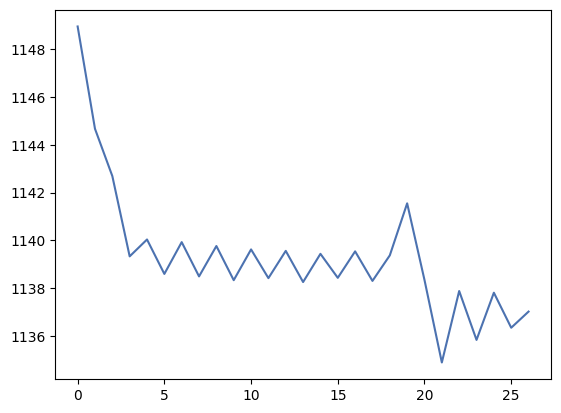

In [16]:
overscan = flat_data[20:-20, 2053:]
overscan_profile_y = numpy.mean(overscan, axis=0)

_ = plt.plot(overscan_profile_y)

This looks better but note the sawtooth pattern, which is caused by the small number of pixels that contribute to the value in each column. Overall, if we wanted to use the overscan region from this image we probably would want to use the regions between 2058 and 2068 pixels approximately.

### Removing the bias level

Now that we have had a good look at the bias images and overscan, we can proceed to remove the contribution of the bias level from our images. We will use `ccd.014.0.fits` as an example. First, let's create a median or "master" bias image from the 6 bias frames using sigma-clipping, and save it to disk

In [17]:
bias_images = []
for i in range(1, 7):
    bias_data = fits.getdata(f'ccd.00{i}.0.fits')
    bias_images.append(bias_data.astype('f4'))

bias_images_masked = sigma_clip(bias_images, cenfunc='median', sigma=2.5, axis=0)
bias_mean_2d = numpy.ma.mean(bias_images_masked, axis=0)

# Create a new HDU list with the bias image. Note that we need
# to use the data attribute of the masked array to get the actual data.
bias_hdu = fits.PrimaryHDU(data=bias_mean_2d.data)
hdul = fits.HDUList([bias_hdu])

# Save the bias image to disk
hdul.writeto('bias.fits', overwrite=True)

Although we haven't done it here, it's a good idea to include a header with information about your median bias. Often you can take one of the original bias headers and add new information to it.

Now let's subtract this bias image from the flat. But before we'll trim the image a bit. This is usually a good idea since electronic defects are usually found near the edges of the image. That is also the region that is usually farther from the optical axis and where aberrations are more pronounced.

In [18]:
# Get the flat data
flat = fits.open('ccd.014.0.fits')

# Trim the image, removing 100 pixels from each side. You can play
# with this value and choose one that makes visual sense for your images.
flat_trim = flat[0].data[100:-100, 100:-100].astype('f4')

# We also need to trim the bias image.
bias_trim = bias_mean_2d[100:-100, 100:-100]

# Now we simply subtract the bias image from the flat image
flat_trim_no_bias = flat_trim - bias_trim.data

# Let's compare the median value before and after the bias subtraction
print(f'Median before: {numpy.ma.median(flat_trim[2000:2100, 1000:1100])}')
print(f'Median after: {numpy.ma.median(flat_trim_no_bias[2000:2100, 1000:1100])}')

Median before: 21910.0
Median after: 20785.833333333332


The level is about 1100 counts lower after removing the bias, which is what we expected. Now we can save the flat image to disk. We will use the original header and add a comment keyword.

In [19]:
# Create a new HDU list with the flat image.
flat_hdu = fits.PrimaryHDU(data=flat_trim_no_bias, header=flat[0].header)

# Add a comment to the header
flat_hdu.header['COMMENT'] = 'Flat-field image with bias subtracted'

# And say what bias image we used
flat_hdu.header['BIASFILE'] = ('bias.fits', 'Bias image used to subtract bias level')

# Save the flat image to disk. Note that if we want a FITS file with
# only one extension we can just save the PrimaryHDU object directly.
flat_hdu.writeto('ccd.014.0_bias.fits', overwrite=True)

# Let's check the header
flat_hdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1880                                                  
NAXIS2  =                 3928                                                  
DATE    = '2016-01-16'          / UT Date of file creation (DD/MM/YY)           
ORIGIN  = 'California Institute of Technology'  / Palomar Observatory           
LATITUDE=              33.4000  / Latitude (degrees N)                          
LONGITUD=            -116.9000  / Longitude (degrees E)                         
TELESCOP= 'Hale 5m Telescope'   / Telescope used for observation                
FRATIO  =               7.5000  / Focal ratio of telescope                      
INSTRUME= 'LFC     '            / Instrument used for observation               
DETECTOR= 'SITe SI002 x 6'  

What if we had decided to use the overscan region instead of the bias frames? We simply need to generate an average overscan level per row and then subtract it from that row in the image.

In [20]:
# Get the overscan region. Note that we use the flat image
# before trimming because the trimming may have removed the
# overscan region. We use only the range 2058-2068 that we
# decided that looked good from our visual analysis.
flat_data = flat[0].data.astype('f4')
overscan = flat_data[:, 2058:2069]

# Now calculate the median along the x axis.
overscan_median = numpy.median(overscan, axis=1)
print(f'Median overscan shape: {overscan_median.shape}')

# Subtract the overscan from the flat image row by row. We need
# to transpose the overscan array to match the shape of the flat image.
flat_no_bias_overscan = flat_data - overscan_median[:, numpy.newaxis]

# Let's trim the final image.
flat_no_bias_overscan_trim = flat_no_bias_overscan[100:-100, 100:-100]

# And get the same statistics as before. Note that we compensate for the
# fact that we have trimmed the overscan-subtracted image.
print(f'Median before: {numpy.median(flat_data[2100:2200, 1100:1200])}')
print(f'Median after: {numpy.median(flat_no_bias_overscan_trim[2000:2100, 1000:1100])}')

# And save the image to disk
flat_hdu = fits.PrimaryHDU(data=flat_no_bias_overscan_trim, header=flat[0].header)
flat_hdu.header['COMMENT'] = 'Flat-field image with overscan subtracted'
flat_hdu.writeto('ccd.014.0_overscan.fits', overwrite=True)

Median overscan shape: (4128,)
Median before: 21910.0
Median after: 20769.0


:::{important}
In general you should subtract an average bias image OR subtract the overscan, but not both (you would end up with a mostly negative image). There are cases in which one may want to use both, for example if the bias level changes significantly during the night but there is also an important spatial dependence in the bias level. In this case a solution is to subtract the overscan for each image but then apply a correction from a normalised bias image, similar to what we will do later for the flat-field correction.
:::

## Measuring the gain and readout noise

As we saw in the previous lecture we can determine the gain and readout noise of a CCD camera by taking a series of images with uniform illumination and different exposure times (and thus different signal levels) and plotting the average signal level against the standard deviation for each pair of images. Alternatively we can use just a couple images with varying signal levels, in which case

$$
\sigma_\Delta^2=2\left(\dfrac{S}{G}+\frac{\sigma_{\rm RN}^22}{G^2}\right)
$$

where $\sigma_\Delta$ is the standard deviation of the difference between the two images, $S$ is the signal level in ADU from one of the images, $G$ is the gain in electrons per ADU, and $\sigma_{\rm RN}$ is the readout noise in ADUs. Remember that we want to use two images to remove the contribution of the fixed pattern noise.

For a quick calculation we can make things even simpler. If we take two images with high signal (but well below saturation) then we can ignore the readout noise and the equation becomes

$$
G = 2\dfrac{S}{\sigma_\Delta^2}
$$

and if we take two images with very low signal we can ignore the signal and write

$$
\sigma_{\rm RN} = \sqrt{\dfrac{\sigma_\Delta^2G^2}{2}}
$$

We actually have the perfect images for this quick calculation. Our flats are good, uniform images with a high signal level, and our biases are, by definition, images without any signal in them. Let's then start by calculating the gain. We will use two flat images for this, `ccd.014.0.fits` and `ccd.015.0.fits`. For this, you should check that the signal levels between both images are very similar.

In [21]:
flat1 = fits.getdata('ccd.014.0.fits').astype('f4')
flat2 = fits.getdata('ccd.015.0.fits').astype('f4')

# Since the images don't have a totally uniform level, we will
# use a range of pixels that we have visually decided looks flat.
# We want these regions to be reasonably large to get good statistics.
flat1_trim = flat1[1600:2000, 1300:1700]
flat2_trim = flat2[1600:2000, 1300:1700]

# Calculate the variance of the difference between the two images
flat_diff = flat1_trim - flat2_trim
flat_diff_var = numpy.var(flat_diff)

# Get the signal as the average of the two images
mean_signal = 0.5 * numpy.mean(flat1_trim + flat2_trim)

# Calculate the gain
gain = 2 * mean_signal / flat_diff_var

print(f'Gain: {gain:.2f} e-/ADU')

Gain: 2.37 e-/ADU


If you check the keyword `GAIN` in the header of the images you'll see it says 1.1, which would make us think that we got this wrong. But if you go to the LFC website and check the [specifications of the camera](https://sites.astro.caltech.edu/palomar/observer/200inchResources/lfcspecs.html#ccd) you can see that the gain actually varies from 1.8 to 2.1. The LFC camera has multiple detectors and our image corresponds to the first one of them, which has a reported gain of 2.0 (always be a bit sceptic about the information that you read in the headers!). It seems we are in the ballpark but this is not a completely accurate measurement, which is not surprising.

Let's now calculate the readout noise from two bias images.

In [22]:
bias1 = fits.getdata('ccd.001.0.fits').astype('f4')
bias2 = fits.getdata('ccd.002.0.fits').astype('f4')

# Here we can use a very large region since the bias level is very flat.
# So we just trim the images to remove the contribution from the edge pixels.
bias1_trim = bias1[1000:-1000, 1000:-1000]
bias2_trim = bias2[1000:-1000, 1000:-1000]

# Calculate the variance of the difference between the two images
bias_diff = bias1_trim - bias2_trim
bias_diff_var = numpy.var(bias_diff)

# Calculate the readout noise
readout_noise_adu = numpy.sqrt(bias_diff_var / 2)
readout_noise_e = readout_noise_adu * gain

print(f'Readout noise (ADU): {readout_noise_adu:.2f} ADU')
print(f'Readout noise (e-): {readout_noise_e:.2f} e-')

Readout noise (ADU): 5.47 ADU
Readout noise (e-): 12.98 e-


Looking at the CCD specifications we would expect a readout noise of about 11 e-, but we seem to be overestimating it by a bit. Part of this is due to the fact that cosmic rays and other defects may be affecting our estimations, which we could improve on by using more images. But the main contributor seems to be the gain. If we use our measured readout noise in ADU (5.47) and multiply it by the gain provided in the LFC website (2.0) we get a readout noise of 10.94 e- which is very close to the expected value. This shows that it's usually easier to get a good, quick estimate of the readout noise than the gain, for which a proper PTC is needed.

## Darks

Dark current noise is generated by the thermal excitation of electrons in the silicon lattice of the CCD. The noise depends strongly on the temperature of the CCD and less strongly on the exposure time. Dark current is often dependent on the position on the CCD as not all parts of the chip register the same temperature. Most professional CCD cameras are cooled to very low temperatures (typically -100 to -150 degrees Celsius) to reduce the dark current to almost negligible levels. That said, it is important to characterise the dark current contribution to our noise budget and, if necessary, correct for it.

This is done by the use of a special type of images called _dark frames_. Dark frames are images taken with the shutter closed and a certain exposure time. Note that this is different from bias frames, which are taken with zero exposure time and a closed shutter. Dark frames should not register any signal from sky sources, so they will only measure the bias level, readout noise, and dark current. Ideally we'll want to take dark frames with the same exposure time as our science images, but this is costly in terms of observing time. For long science exposure times we often take dark frames with a short exposure time (5-10 minutes) and determine the dark current level per second. Tht image can then be scaled to the exposure time of our science images and subtracted. As with bias frames, we should take several dark frames for each exposure time and combine to reduce their noise level.

Our dataset includes a series of frames with different exposure times. Let's start by looking at them very broadly.

In [23]:
import glob
files = sorted(glob.glob('./darks/ccd.*.0.fits'))
print(files)

for file in files:
    dark = fits.open(file)
    dark_data = dark[0].data.astype('f4')[1000:1100, 1000:1100]
    print(f'{file} - {dark[0].header["IMAGETYP"]} - {dark[0].header["EXPTIME"]} - {numpy.median(dark_data):.2f}  - {numpy.std(dark_data):.2f}')

['./darks/ccd.002.0.fits', './darks/ccd.013.0.fits', './darks/ccd.014.0.fits', './darks/ccd.015.0.fits', './darks/ccd.017.0.fits', './darks/ccd.018.0.fits', './darks/ccd.019.0.fits', './darks/ccd.023.0.fits', './darks/ccd.024.0.fits', './darks/ccd.025.0.fits']
./darks/ccd.002.0.fits - BIAS - 0.0 - 1176.00  - 4.15
./darks/ccd.013.0.fits - DARK - 300.0 - 1198.00  - 4.98
./darks/ccd.014.0.fits - DARK - 300.0 - 1198.00  - 5.84
./darks/ccd.015.0.fits - DARK - 300.0 - 1198.00  - 5.22
./darks/ccd.017.0.fits - DARK - 70.0 - 1186.00  - 4.40
./darks/ccd.018.0.fits - DARK - 70.0 - 1186.00  - 4.37
./darks/ccd.019.0.fits - DARK - 70.0 - 1184.00  - 4.38
./darks/ccd.023.0.fits - DARK - 7.0 - 1171.00  - 4.12
./darks/ccd.024.0.fits - DARK - 7.0 - 1169.00  - 4.05
./darks/ccd.025.0.fits - DARK - 7.0 - 1169.00  - 4.12


The first image is actually a bias which we can use as a reference. Note that the bias level is a bit higher than the other biases we have seen so far. It may have been taken on a different day or with a different readout mode. For the darks we see that the average level increases a bit with exposure time. For 7 seconds the level is actually lower than the bias (which can be just statistical noise or some especially hot pixels on the bias). As we move to longer exposure times we start to see some increase in the level, with 300s flats being about 20 counts higher than the bias. While this may not seem like much, it could be important if we are trying to measure very faint sources in low S/N conditions.

We will begin by correcting all dark frames using the master bias image that we created before and saving them to disk.

In [24]:
bias = fits.getdata('bias.fits')
for file in files:
    dark = fits.open(file)

    # Ignore the bias image.
    if dark[0].header['IMAGETYP'] == 'BIAS':
        continue

    dark_data = dark[0].data.astype('f4')
    dark_data_no_bias = dark_data - bias

    # Create a new HDU list with the dark image.
    dark_hdu = fits.PrimaryHDU(data=dark_data_no_bias, header=dark[0].header)

    # Add a comment to the header
    dark_hdu.header['COMMENT'] = 'Dark image with bias subtracted'
    dark_hdu.header['BIASFILE'] = ('bias.fits', 'Bias image used to subtract bias level')

    # Create a new filename for the dark image.
    dark_no_bias_filename = file.replace('.fits', '_bias.fits')

    # Save the dark image to disk
    dark_hdu.writeto(dark_no_bias_filename, overwrite=True)

Now let's combine the dark frames. There are different ways to do this. We could combine each set of dark frames for an exposure time and create median darks for each of those exposures times. Instead we'll use the three darks with the longest exposure time and normalise them.

In [25]:
dark_bias_files = ['./darks/ccd.013.0_bias.fits', './darks/ccd.014.0_bias.fits', './darks/ccd.015.0_bias.fits']
dark_bias_data = []

for file in dark_bias_files:
    dark = fits.open(file)
    dark_data = dark[0].data.astype('f4')
    exptime = dark[0].header['EXPTIME']
    dark_bias_data.append(dark_data / exptime)

  # Sigma-clip the dark frames
dark_sc = sigma_clip(dark_bias_data, cenfunc='median', sigma=3, axis=0)

# And now combine them.
dark_combined = numpy.ma.mean(dark_sc, axis=0)

# Save the combined dark frame to disk. We'll use the header from the last
# dark frame. We set the EXPTIME to 1 second.
dark_hdu = fits.PrimaryHDU(data=dark_combined.data, header=dark[0].header)
dark_hdu.header['EXPTIME'] = 1
dark_hdu.header['COMMENT'] = 'Combined dark image with bias subtracted'
dark_hdu.header['BIASFILE'] = ('bias.fits', 'Bias image used to subtract bias level')

# Save the dark image to disk
dark_hdu.writeto('dark.fits', overwrite=True)

## Flats

Flat-fielding is a process that is closely related to the fixed pattern noise that we saw in the previous lecture. Pixels in a detector don't all respond the same way to incident light. That is, the quantum efficiency of each pixel, which ideally would be 100% in the visible range, is not the same for all pixels. Usually the differences are small, in the few percent range, but that is enough for fixed pattern noise to quickly become the dominant source of noise when images have significant signal levels.

Fortunately, fixed pattern noise (FPN) is highly systematic (the same pixel will have the same response every time) and we can correct for it. Note that while quantum efficiency is the dominant cause of FPN in an otherwise perfect detector, factors such as dust, scratches, and other defects can also contribute to FPN. The contribution of those factors can sometimes change from night to night which requires measuring the FPN before each observation.

FPN is usually measured using a series of _flat-field images_ or _flats_. Flats are images with significant, _uniform_ illumination of the CCD which allow us to determine the relative response of each pixel. There are three main types of flats:

- Dome flats: these are taken with a uniform illumination of the dome of the telescope. Usually a flat-field screen is placed somewhere and illuminated with a halogen lamp. The telescope is then pointed to that screen and, since the screen is not at infinity, the resulting image is likely to produce a good, uniform flat-field image.
- Twilight flats: these are taken at twilight, when the sky is still bright but the Sun is below the horizon. During twilight the sky provides a very uniform illumination. Twilight flats may be difficult to take as the background of the sky changes rapidly and provides different illumination at different wavelengths, which requires quickly adjusting exposure times. The resulting S/N levels are usually lower than with dome flats. To avoid stars affecting the twilight flats the telescope can be left stationary, without tracking. When multiple images are combined the stars will fall on different pixels on the CCD and they can be sigma-clipped out. Alternatively one can introduce small offsets on the position of the telescope between images.
- Sky flats: these are taken during the night or even generated from a series of science images. By combining a large number of science frames from different fields we can remove the contribution of stars (or write an algorithm that ignore them when generating a modelled flat) and create a flat-field image. This image provides, in principle, the closest approximation to the actual sky illumination and to what the science images see, but is usually affected by very low S/N.

For most observations we use a combination of dome and twilight flats. In the evening (or morning) we point the telescope towards the West horizon (East in the morning) at an altitude of about 40 degrees, which provides the most uniform illumination across the FoV of the telescope. We then take exposures on each filter with the goal of getting about 50% the saturation level (25-30,000 counts for most cameras). This is often not possible for all filters during twilight flats, and some trade-offs need to be decided between the number of filters to observe and how much signal we can get on each one. We start with the narrow-band filters while the solar illumination is still high and then move to the broad-band filters from blue to red. Between exposures, you can move the telescope in a diagonal (30 arcsec in RA, 30 arcsec in Dec) to avoid stars falling on the same pixels.

After the twilight flats, we will usually take a set of dome flats, following the procedure specified by the observatory. This usually entails pointing the telescope to a specific position on the dome, turning on the lamp used for flats, and taking exposures in all filters while making sure we get as high a signal as possible without going over 60% of the saturation level.

Either the twilight flats or the dome flats can be used (after correcting them from bias and potentially dark current) to create a master flat image, which is then normalised by the median value of the image to create a normalised flat. If we have both twilight and dome flats, we can try to combine them to create a better flat-field image. The idea is to use the twilight flats to correct for the low-order illumination effects and the dome flats, with higher S/N, to account for the higher-order, pixel-to-pixel variations. For that we combine and normalise the twilight flats and use them to correct the dome flats. We then combine and normalise the dome flats and fit a low-order, two-dimensional polynomial to the resulting image. This model contains information about the the non-uniformities in the dome flat-field screen. Finally we divide the normalised dome flat by the model to remove the screen contributions.

### Combining and normalising flats

Our dataset only includes dome flats, so we will only use those, but later we will see how we could create a low-order modelled flat.

Images 14 to 19 in our dataset are dome flats. Let's start by looking at their exposure times, average levels, and filters.

In [26]:
for ii in range(14, 20):
    fname = f'ccd.0{ii}.0.fits'
    flat = fits.open(fname)
    flat_data = flat[0].data.astype('f4')[500:-500, 500:-500]
    print(f'{fname} - {flat[0].header["IMAGETYP"]} - {flat[0].header["EXPTIME"]} - '
          f'{flat[0].header["FILTER"]} - {numpy.median(flat_data):.2f}')

ccd.014.0.fits - FLATFIELD - 70.001 - g' - 21559.00
ccd.015.0.fits - FLATFIELD - 70.011 - g' - 21556.00
ccd.016.0.fits - FLATFIELD - 70.001 - g' - 21544.00
ccd.017.0.fits - FLATFIELD - 7.0 - i' - 22233.00
ccd.018.0.fits - FLATFIELD - 7.0 - i' - 22243.00
ccd.019.0.fits - FLATFIELD - 7.0 - i' - 22257.00


We have flats for two different filters, `g'` and `'`, taken with different exposure times. The signal levels for all the images look reasonable. Let's look at one of the `g'` flats.

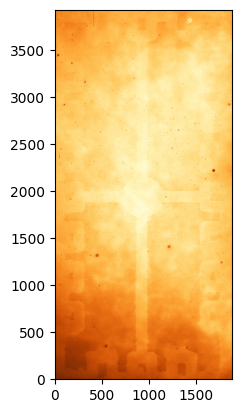

In [27]:
flat = fits.open('ccd.014.0.fits')
flat_data = flat[0].data.astype('f4')[100:-100, 100:-100]

# Plot the flat image
norm = ImageNormalize(flat_data, interval=ZScaleInterval(), stretch=LinearStretch())
_ = plt.imshow(flat_data, origin='lower', norm=norm, cmap='YlOrBr_r')

Unlike for bias and dark frames there is a lot of structure here. First, we notice some stars on the image. We will need to be careful to make sure that those stars disappear after we combine the flats. Most importantly, we see a non-uniform field with two main features: the lower and upper parts of the image have higher signal levels and there is a gradient towards the centre; and there is a cross-like "shadow" and square features on the edges of the image which are part of the CCD electronics. We also see a series of darker spots, which are places where the CCD substrate was not properly thinned.

Let's combine the images for the `g'` filter (we'll leave the `i'` ones as an exercise).

:::{hint}
Although we will not use it in this course, the [ccdproc](https://ccdproc.readthedocs.io/en/latest/) package (based on the classic IRAF `ccdproc`) automatically allows to handle and combine flats from multiple filters, provided that the headers are set up correctly.
:::

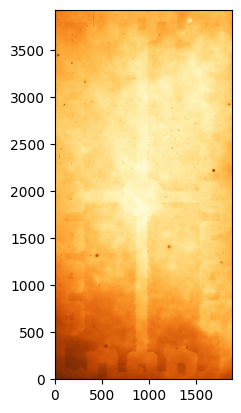

In [28]:
# Get the list of flats for the g' filter and subtract the bias level.
# We'll consider that the dark current is negligible for the flats.
flats_g = []
for ii in range(14, 20):
    fname = f'ccd.0{ii}.0.fits'
    flat = fits.open(fname)
    if flat[0].header['FILTER'] == "g'":
        flats_g.append(flat[0].data.astype('f4') - bias_mean_2d)


# Mask using sigma-clipping
flats_g_masked = sigma_clip(flats_g, cenfunc='median', sigma=2, axis=0)

# Combine the flats
flat_g_combined = numpy.ma.median(flats_g_masked, axis=0).data
flat_g_combined_trim = flat_g_combined[100:-100, 100:-100]

# Plot the combined flat
norm = ImageNormalize(flat_g_combined_trim, interval=ZScaleInterval(), stretch=LinearStretch())
_ = plt.imshow(flat_g_combined_trim, origin='lower', norm=norm, cmap='YlOrBr_r')

Now we need to normalise the flat by its median or mode level (you can try both, although it often comes down to personal preference). For this we will avoid using the edges of the image which are more affected by noise and include the overscan regions. Later, for the science images, we will trim the images to the same size.

In [29]:
from scipy.stats import mode

# Calculate the median of the flat image.
# We want to calculate the mode so need to use scipy.stats for
# which we first need to flatten the image. You can replace this
# with how we usually calculate the median. We also trim 100 pixels on each side.
(flat_mode, _) = mode(flat_g_combined[100:-100, 100:-100].flatten(), nan_policy='omit')
print(f'Mode: {flat_mode:.0f}')

# Normalise the flat image
flat_g_norm = flat_g_combined / flat_mode

# Mask out pixels with zero value since those will fail when we divide
# by the flat later. We replace them with 1s that will not affect the result.
flat_g_norm[flat_g_combined == 0] = 1

# Save the normalised flat image to disk
flat_g_hdu = fits.PrimaryHDU(data=flat_g_norm, header=flat[0].header)
flat_g_hdu.header['COMMENT'] = 'Normalised flat-field image'
flat_g_hdu.header['BIASFILE'] = ('bias.fits', 'Bias image used to subtract bias level')
flat_g_hdu.writeto('flat_g.fits', overwrite=True)

Mode: 20354


We do not plot the normalised flat since it will look identical to the non-normalised one except for a scale factor.

### Modelling flat images

Finally, let's imagine that this was a twilight flat and we want to fit a low-order polynomial to it to get the low-frequency structure. We can use `astopy.modeling` to do this.

In [30]:
# Ignore this cell, which is only used to prevent some harmless warnings in the
# next cell.
import warnings
from astropy.utils.exceptions import AstropyUserWarning

warnings.filterwarnings('ignore', category=AstropyUserWarning)

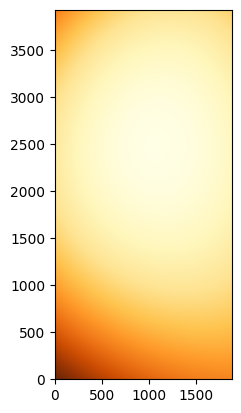

In [31]:
from astropy.modeling import models, fitting

# Remove the edges which may affect the fitting.
flat_g_norm_trim = flat_g_norm[100:-100, 100:-100]

# Create a grid of x and y coordinates from the image shape.
x, y = numpy.mgrid[0:flat_g_norm_trim.shape[0], 0:flat_g_norm_trim.shape[1]]

# Initialise a polynomial model of degree 3 and the fitter (essentially a least-squares).
p_init = models.Polynomial2D(degree=3)
fit_p = fitting.LMLSQFitter()

# Fit the model to the flat image.
model = fit_p(p_init, x, y, flat_g_norm_trim)

# Create a new image from the original grid but using the model.
flat_g_model = model(x, y)

# Plot the model
norm = ImageNormalize(flat_g_model, interval=ZScaleInterval(), stretch=LinearStretch())
_ = plt.imshow(flat_g_model, origin='lower', norm=norm, cmap='YlOrBr_r')

We can see that we are missing a lot of the high-frequency structure, but we have correctly captured the main shape of the illumination patter, including the direction of the gradients.

(basic-ccd-reductions-science)=

## Science images

Now that we have processed and combined all our calibration images, we can proceed to apply those corrections to our science images. The process is relatively straightforward and consists of the following steps:

- Subtract the bias level from the science image.
- Subtract the dark current from the science image.
- Divide the science image by the normalized flat-field image. This corrects the pixel-to-pixel variations in the CCD response.
- Trim the image to remove the edges and overscan regions.

In our dataset, image 37 is a science image taken with the `g'` filter. Let's start by looking at it.

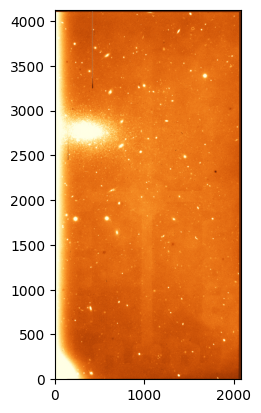

In [32]:
science = fits.open('ccd.037.0.fits')
science_data = science[0].data.astype('f4')

# Plot the science image. Scale by a trimmed region to avoid the edges but plot the full image.
norm_orig = ImageNormalize(science_data[100:-100, 100:-100], interval=ZScaleInterval(), stretch=LinearStretch())
_ = plt.imshow(science_data, origin='lower', norm=norm_orig, cmap='YlOrBr_r')

The image shows an open cluster along with some other field stars and galaxies. Note that we can see some of the features that we pointed out earlier when talking about the flat. Let's go ahead and correct it.

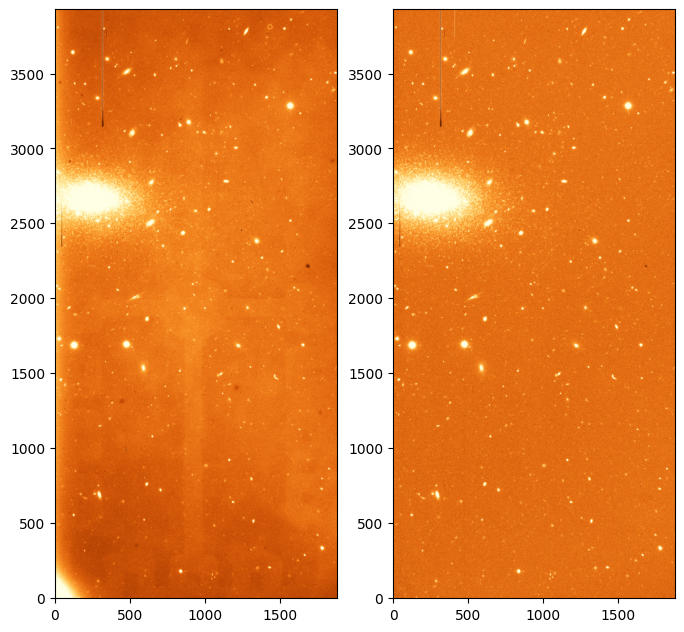

In [33]:
# Subtract the bias level
bias_data = fits.getdata('bias.fits').astype('f4')
science_data_proc = science_data - bias_data

# Get the exposure time from the header
exptime = science[0].header['EXPTIME']

# Subtract the dark current, scaled to the exposure time
dark_data = fits.getdata('dark.fits').astype('f4')
dark_data_scaled = dark_data * exptime
science_data_proc -= dark_data_scaled

# Divide by the normalised flat-field image
flat_data = fits.getdata('flat_g.fits').astype('f4')
science_data_proc /= flat_data

# Trim the image to remove the edges and overscan regions
science_data_proc = science_data_proc[100:-100, 100:-100]

# Plot the final image along the original one to compare.
norm = ImageNormalize(science_data_proc, interval=ZScaleInterval(), stretch=LinearStretch())

fig, axes = plt.subplots(1, 2, figsize=(8, 12))
_ = axes[0].imshow(science_data[100:-100, 100:-100], origin='lower', norm=norm_orig, cmap='YlOrBr_r')
_ = axes[1].imshow(science_data_proc, origin='lower', norm=norm, cmap='YlOrBr_r')

# Save the final image to disk
science_hdu = fits.PrimaryHDU(data=science_data_proc, header=science[0].header)
science_hdu.header['COMMENT'] = 'Final science image'
science_hdu.header['BIASFILE'] = ('bias.fits', 'Bias image used to subtract bias level')
science_hdu.header['DARKFILE'] = ('dark.fits', 'Dark image used to subtract dark current')
science_hdu.header['FLATFILE'] = ('flat_g.fits', 'Flat-field image used to correct flat-fielding')
science_hdu.writeto('ccd.037.0_proc.fits', overwrite=True)

Note how the image has improved. The flat features have disppeared and the image looks much "flatter". The gradient on the lower left corner, which is caused mainly by thermal noise has also disappeared thanks to removing the dark contribution.

We can do one more check to see how much the image has improved. Let's make a profile of both the raw and processed images along the y-axis. We'll use sigma-clipping to try to remove some of the contributions from the stars and other sources.

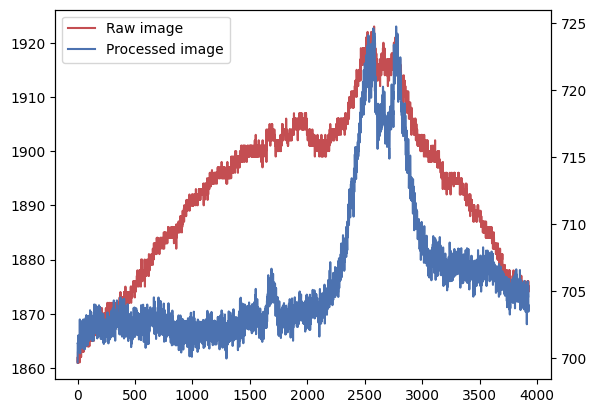

In [34]:
# Trim the original image so that it has the same size as the processed one.
science_data_trim = science_data[100:-100, 100:-100]

# Calculate the median along the y-axis. Reject pixels using sigma-clipping.
science_data_trim_masked = sigma_clip(science_data_trim, cenfunc='median', sigma=3, axis=1)
science_data_trim_profile = numpy.ma.median(science_data_trim_masked, axis=1)

# Do the same for the processed image
science_data_proc_masked = sigma_clip(science_data_proc, cenfunc='median', sigma=3, axis=1)
science_data_proc_profile = numpy.ma.median(science_data_proc_masked, axis=1)

# Plot the profiles
l1, = plt.plot(science_data_trim_profile, 'r-')
_ = plt.twinx()  # New y-axis because the raw and process images have different base levels
l2, = plt.plot(science_data_proc_profile, 'b-')

_ = plt.legend([l1, l2], ['Raw image', 'Processed image'])

The processed image has a flatter profile, which is expected as we have removed many of the sources of non-uniformity, such as the flat-field. The peak between 2500 and 3000 pixels corresponds to the open cluster, which occupies many pixels on the image and has not been fully removed by the sigma-clipping.

## Cosmic ray removal

So far we have been able to remove most of the cosmic rays affecting our images by sigma-clipping. We can do the same for science images if we are taking multiple of them for each target, with approximately the same exposure time. But even if that is possible we may want to avoid sigma-clipping science images because we risk removing good science data, which would reduce or final S/N. Instead we can use special algorithms to mask out cosmic rays.

The most widely used algorithm for cosmic ray removal is the [van Dokkum (2001)](https://iopscience.iop.org/article/10.1086/323894/pdf) method, which looks at the variation of Laplacian edge detection. Cosmic rays have edges that are "shaper" than the type of Gaussian profile that we expect from stars and other sources. This algorithm is very robust for all kinds of cosmic rays, regardles of their shape and intensity.

A good implementation of this algorithm is [astroscrappy](https://astroscrappy.readthedocs.io/en/latest/index.html). We'll use it to generate a mask for the cosmic rays in our final science image.

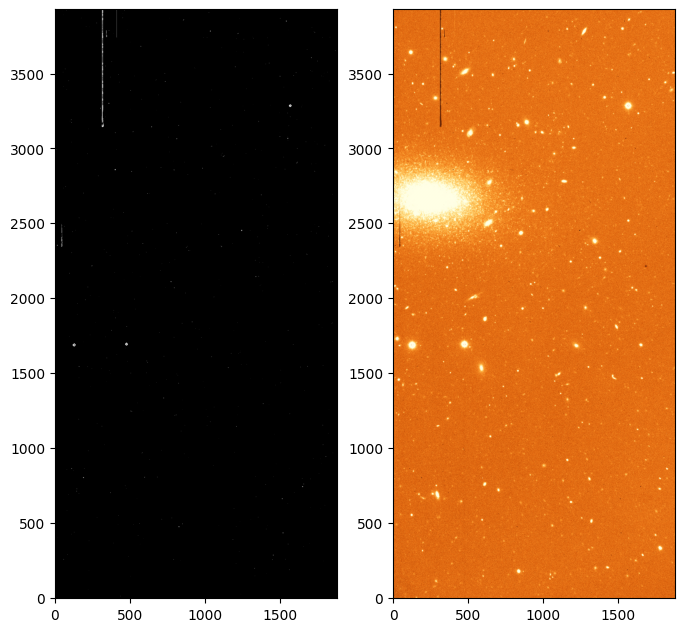

In [35]:
from astroscrappy import detect_cosmics

# Generate the cosmic ray mask and a cleaned image
mask, cleaned = detect_cosmics(science_data_proc)

# Plot the mask and the cleaned image
fig, axes = plt.subplots(1, 2, figsize=(8, 12))
_ = axes[0].imshow(mask, origin='lower', cmap='gray')
_ = axes[1].imshow(cleaned, origin='lower', norm=norm, cmap='YlOrBr_r')

On the left we can see the mask of cosmic rays, with locations on the image that are flagged as cosmics in white (value `True` or `1`). On the right we see a cleaned image that is constructed by trying to replace the masked cosmics rays with an average of the surrounding pixels. Note that not all the cosmic rays and defects are removed. In particular the vertical columns are wider than the size the cleaning algorithm is able to handle (they are likely to be electronic defects or scratches). We are also detecting some features that have sharp edges but are not cosmic rays, such as the bad columns that we just mentioned and the centres of some of the stars, which are saturated and thus have a very sharp profile.